In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Import

In [2]:
import copy

from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary
from transformers import ViTModel, AutoImageProcessor, BertModel, AutoTokenizer

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder

from architecture import Transformer
from architecture_detail import *

import cv2

device = torch.device("cuda")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [3]:
test_mode = True

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 100
PRED_LEN = 100

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "nlp": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day",  "dow", "month", "holiday"],
    "img_cols": ["img_path"],
    "nlp_cols": []
}

# Model
batch_size = 32
nhead = 4
dropout = 0.1
patch_size = 16

d_model = {"encoder":256, "decoder":128}
d_ff = {"encoder":256, "decoder":128}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"target":0.25, "temporal":0.25, "img":0.25, "nlp":0.25}

# Data

### Raw data

In [4]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [5]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_train = df_train[~pd.isna(df_train["detail_desc"])]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]
df_valid = df_valid[~pd.isna(df_valid["detail_desc"])]

data_info = DataInfo(modality_info, processing_info)

In [6]:
train_dataset = Dataset(df_train, data_info, remain_rto)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items() if "scaler" not in key and "raw" not in key]
    break

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
data["temporal_padding_mask"]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

# Architecture

In [ ]:
class MultiheadBlockSelfAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout):
        super().__init__()
        self.nhead = nhead
        
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)
    
    def forward(self, query, key, value, block_idx_dict, block_padding_mask_dict):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, self.nhead, d_model//self.nhead).permute(0,2,1,3)
        K = K.view(batch_size, seq_len, self.nhead, d_model//self.nhead).permute(0,2,1,3)
        V = V.view(batch_size, seq_len, self.nhead, d_model//self.nhead).permute(0,2,1,3)

        # Scaled dot product attention
        temporal_side_attn_output, temporal_side_attn_weight = self.temporal_side_attention(Q, K, V, block_idx_dict, block_padding_mask_dict)
        static_side_attn_output, static_side_attn_weight = self.static_side_attention(Q, K, V, block_idx_dict, block_padding_mask_dict)

        attn_output = torch.cat([temporal_side_attn_output, static_side_attn_output], dim=1)
        assert query.shape == attn_output.shape
        
        return attn_output, temporal_side_attn_weight, static_side_attn_weight
    
    def temporal_side_attention(self, Q, K, V, block_idx_dict, block_padding_mask_dict):
        batch_size, nhead, _, d_model_ = Q.shape

        temporal_idx = block_idx_dict["temporal"].unsqueeze(0).unsqueeze(1).unsqueeze(-1).repeat(batch_size, nhead, 1, d_model_)
        static_idx = block_idx_dict["static"].unsqueeze(0).unsqueeze(1).unsqueeze(-1).repeat(batch_size, nhead, 1, d_model_)

        temporal_padding_mask = block_padding_mask_dict["temporal_remain_padding_mask"]
        static_padding_mask = block_padding_mask_dict["static_remain_padding_mask"]

        batch_size, seq_len, num_modality = temporal_padding_mask.shape

        # 1. Temp-Temp
        Qt = torch.gather(Q, index=temporal_idx, dim=-2).view(batch_size, nhead, seq_len, num_modality, -1)
        Kt = torch.gather(K, index=temporal_idx, dim=-2).view(batch_size, nhead, seq_len, num_modality, -1)
        ### 1-1. Scaled dot product attention
        QtKt = Qt @ Kt.permute(0,1,2,4,3)
        QtKt = QtKt / math.sqrt(d_model_)
        ### 1-2. Padding mask
        temporal_padding_mask = temporal_padding_mask.unsqueeze(1).unsqueeze(-2)
        temporal_padding_mask = torch.where(temporal_padding_mask==1, 0, -torch.inf)
        QtKt += temporal_padding_mask

        # 2. Temp-Static
        Ks = torch.gather(K, index=static_idx, dim=-2).unsqueeze(-3)
        ### 2-1. Scaled dot product attention
        QtKs = Qt @ Ks.permute(0,1,2,4,3)
        QtKs = QtKs / math.sqrt(d_model_)
        ### 2-2. Padding mask
        static_padding_mask = static_padding_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        static_padding_mask = torch.where(static_padding_mask==1, 0, -torch.inf)
        QtKs += static_padding_mask

        # 3. Concat & Softmax & Split
        ### Concat
        QK = torch.cat([QtKt, QtKs], dim=-1)
        ### Softmax
        attn_weight = torch.nn.functional.softmax(QK, dim=-1)
        ### Split
        QtKt = attn_weight[:, :, :, :, :QtKt.shape[-1]]
        QtKs = attn_weight[:, :, :, :, QtKt.shape[-1]:]

        # 4. Temp-Temp-Temp
        Vt = torch.gather(V, index=temporal_idx, dim=-2).view(batch_size, nhead, seq_len, num_modality, -1)
        QtKtVt = QtKt @ Vt
        
        # 5. Temp-Static-Static
        Vs = torch.gather(V, index=static_idx, dim=-2).unsqueeze(-3)
        QtKsVs = QtKs @ Vs
        
        attn_output = QtKtVt + QtKsVs
        
        # 6. Concat heads
        attn_output = attn_output.permute(0,2,3,1,4).reshape(batch_size, seq_len*num_modality, -1)
        
        return attn_output, attn_weight

    def static_side_attention(self, Q, K, V, block_idx_dict, block_padding_mask_dict):
        # Obtain QKV
        batch_size, nhead, _, d_model_ = Q.shape
        temporal_idx = block_idx_dict["temporal"].unsqueeze(0).unsqueeze(1).unsqueeze(-1).repeat(batch_size, nhead, 1, d_model_)
        static_idx = block_idx_dict["static"].unsqueeze(0).unsqueeze(1).unsqueeze(-1).repeat(batch_size, nhead, 1, d_model_)

        temporal_padding_mask = block_padding_mask_dict["temporal_remain_padding_mask"]
        static_padding_mask = block_padding_mask_dict["static_remain_padding_mask"]

        batch_size, seq_len, num_modality = temporal_padding_mask.shape

        # 1. Static-Temp
        Qs = torch.gather(Q, index=static_idx, dim=-2)
        Kt = torch.gather(K, index=temporal_idx, dim=-2)
        ### 1-1. Scaled dot product attention
        QsKt = Qs @ Kt.permute(0,1,3,2)
        QsKt = QsKt / math.sqrt(d_model_)
        ### 1-2. Padding mask
        temporal_padding_mask = temporal_padding_mask.view(temporal_padding_mask.shape[0], -1)
        temporal_padding_mask = temporal_padding_mask.unsqueeze(1).unsqueeze(2)
        temporal_padding_mask = torch.where(temporal_padding_mask==1, 0, -torch.inf)
        QsKt += temporal_padding_mask

        # 2. Static-Static
        Ks = torch.gather(K, index=static_idx, dim=-2)
        ### 2-1. Scaled dot product attention
        QsKs = Qs @ Ks.permute(0,1,3,2)
        QsKs = QsKs / math.sqrt(d_model_)
        ### 2-2. Padding mask
        static_padding_mask = static_padding_mask.unsqueeze(1).unsqueeze(2)
        static_padding_mask = torch.where(static_padding_mask==1, 0, -torch.inf)
        QsKs += QsKs

        # 3. Concat & Softmax & Split
        ### Concat
        QK = torch.cat([QsKt, QsKs], dim=-1)
        ### Softmax
        attn_weight = torch.nn.functional.softmax(QK, dim=-1)
        ### Split
        QsKt = attn_weight[:, :, :, :QsKt.shape[-1]]
        QsKs = attn_weight[:, :, :, QsKt.shape[-1]:]

        # 4. Static-Temp-Temp
        Vt = torch.gather(V, index=temporal_idx, dim=-2)
        QsKtVt = QsKt @ Vt
        
        # 5. Static-Static-Staic
        Vs = torch.gather(V, index=static_idx, dim=-2)
        QsKsVs = QsKs @ Vs

        attn_output = QsKtVt + QsKsVs
        
        # 6. Concat heads
        attn_output = attn_output.permute(0,2,1,3).reshape(batch_size, -1, nhead*d_model_)

        return attn_output, attn_weight
        
class MultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super().__init__()
        self.nhead = nhead
        
        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)
    
    def forward(self, query_dict, key_dict, value_dict, padding_mask_dict):
        result_output_dict, result_weight_dict = {}, {}
        query_temporal = True if "temporal" in query_dict.keys() else False
        query_static = True if "static" in query_dict.keys() else False

        key_temporal = True if "temporal" in key_dict.keys() else False
        key_static = True if "static" in key_dict.keys() else False

        # 1-1. Temp @ Temp + padding_mask
        if query_temporal and key_temporal:
            QtKt, Vt = self.temporal_temporal(query_dict["temporal"], key_dict["temporal"], value_dict["temporal"], padding_mask_dict["temporal"])
        
        # 1-2. Temp @ Static + padding_mask
        if query_temporal and key_static:
            QtKs, Vs = self.temporal_static(query_dict["temporal"], key_dict["static"], value_dict["static"], padding_mask_dict["static"])

        if query_temporal:
            if key_temporal and not key_static:
                QK = QtKt
                attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                QKV = attn_weight @ Vt
            elif not key_temporal and key_static:
                QK = QtKs
                attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                QKV = attn_weight @ Vs
            elif key_temporal and key_static:
                QK = torch.cat([QtKt, QtKs], dim=-1)
                attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                
                QtKt_weight = attn_weight[:, :, :, :, :QtKt.shape[-1]]
                QtKs_weight = attn_weight[:, :, :, :, QtKt.shape[-1]:]

                QtKtVt = QtKt_weight @ Vt
                QtKsVs = QtKs_weight @ Vs

                QKV = QtKtVt + QtKsVs
            
            # 1-3. Concat head
            batch_size, nheads, seq_len, num_modality, _ = QKV.shape
            attn_output = QKV.permute(0,2,3,1,4).reshape(batch_size, seq_len, num_modality, -1)
            
            result_output_dict["temporal"] = attn_output
            result_weight_dict["temporal"] = attn_weight

        # 2-1. Static-Temp
        if query_static and key_temporal:
            QsKt, Vt = self.static_temporal(query_dict["static"], key_dict["temporal"], value_dict["temporal"], padding_mask_dict["temporal"])

        # 2-2. Static-Static
        if query_static and key_static:
            QsKs, Vs = self.static_static(query_dict["static"], key_dict["static"], value_dict["static"], padding_mask_dict["static"])
        
        if query_static:
            if key_temporal and not key_static:
                QK = QsKt
                attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                QKV = attn_weight @ Vt
            elif not key_temporal and key_static:
                QK = QsKs
                attn_weight = torch.nn.functional.softmax(QK, dim=-1)
                QKV = attn_weight @ Vs
            elif key_temporal and key_static:
                QK = torch.cat([QsKt, QsKs], dim=-1)
                attn_weight = torch.nn.functional.softmax(QK, dim=-1)

                QsKt_weight = attn_weight[:, :, :, :QsKt.shape[-1]]
                QsKs_weight = attn_weight[:, :, :, QsKt.shape[-1]:]

                QsKtVt = QsKt_weight @ Vt
                QsKsVs = QsKs_weight @ Vs

                QKV = QsKtVt + QsKsVs
            
            # 2-3. Concat head
            batch_size, nheads, seq_len, _ = QKV.shape
            attn_output = QKV.permute(0,2,1,3).reshape(batch_size, seq_len, -1)

            result_output_dict["static"] = attn_output
            result_weight_dict["static"] = attn_weight

        return result_output_dict, result_weight_dict

    def temporal_temporal(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, _, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0,3,1,2,4)
        K = K.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0,3,1,2,4)
        V = V.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0,3,1,2,4)

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,2,4,3)
        QK = QK / math.sqrt(QK.shape[-1]//self.nhead)
        
        # Padding mask
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(-2)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        QK += padding_mask
        
        return QK, V
    
    def temporal_static(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, _, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0,3,1,2,4)
        K = K.view(batch_size, -1, self.nhead, d_model//self.nhead).permute(0,2,1,3).unsqueeze(-3)
        V = V.view(batch_size, -1, self.nhead, d_model//self.nhead).permute(0,2,1,3).unsqueeze(-3)

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,2,4,3)
        QK = QK / math.sqrt(QK.shape[-1]//self.nhead)

        # Padding mask
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        QK += padding_mask
        
        return QK, V

    def static_temporal(self, query, key, value, padding_mask):
        key = key.view(key.shape[0], -1, key.shape[-1])
        value = value.view(value.shape[0], -1, value.shape[-1])

        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, self.nhead, d_model//self.nhead).permute(0,2,1,3)
        K = V.view(batch_size, -1, self.nhead, d_model//self.nhead).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.nhead, d_model//self.nhead).permute(0,2,1,3)
        

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,3,2)
        QK = QK / math.sqrt(QK.shape[-1]//self.nhead)
        
        # Padding mask
        padding_mask = padding_mask.view(padding_mask.shape[0], -1).unsqueeze(1).unsqueeze(2)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        QK += padding_mask
        
        return QK, V

    def static_static(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, self.nhead, d_model//self.nhead).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.nhead, d_model//self.nhead).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.nhead, d_model//self.nhead).permute(0,2,1,3)

        # Scaled dot product attention
        QK = Q @ K.permute(0,1,3,2)
        QK = QK / math.sqrt(QK.shape[-1]//self.nhead)

        # Padding mask
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)
        padding_mask = torch.where(padding_mask==1, 0, -torch.inf)
        QK += padding_mask
        
        return QK, V

1==1

True

In [ ]:
class TemporalEmbedding(torch.nn.Module):
    def __init__(self, data_info, num_cls_dict, d_model):
        super().__init__()
        self.data_info = data_info

        self.linear_embedding = torch.nn.Linear(1, d_model)
        
        self.categorical_embedding_dict = torch.nn.ModuleDict()
        for col, num_cls in num_cls_dict.items():
            self.categorical_embedding_dict[col] = torch.nn.Embedding(num_cls, d_model)
    
    def forward(self, col, data):
        if col in self.data_info.processing_info["scaling_cols"]:
            embedding = self.linear_embedding(data)
        elif col in self.data_info.processing_info["embedding_cols"]:
            embedding = self.categorical_embedding_dict[col](data)
        
        return embedding
    
class ImgEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.downsize_linear = torch.nn.Linear(768, d_model)
    
    def forward(self, data):
        embedding = self.img_model(data).last_hidden_state
        embedding = self.downsize_linear(embedding)
        return embedding

class NlpEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.nlp_model = BertModel.from_pretrained("google-bert/bert-base-uncased")
        self.downsize_linear = torch.nn.Linear(768, d_model)   
    
    def forward(self, col, data, padding_mask_dict, device):
        # Make token_type_ids
        token_type_ids = torch.zeros(data.shape).to(torch.int).to(device)

        # Make attention mask
        attention_mask = padding_mask_dict[f"{col}_revert_padding_mask"]

        # Embed data
        inputs = {"input_ids":data, "token_type_ids":token_type_ids, "attention_mask":attention_mask}
        embedding = self.nlp_model(**inputs).last_hidden_state
        embedding = self.downsize_linear(embedding)
        
        return embedding


class TemporalRemain(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data_dict, idx_dict, padding_mask_dict, remain_rto, global_temporal_cols, device):
        # Block out temporal data
        block_li, block_padding_mask_li = [], []

        for col in global_temporal_cols:
            temporal_data = data_dict[col]
            padding_mask = padding_mask_dict["temporal_padding_mask"]

            block_li.append(temporal_data)
            block_padding_mask_li.append(padding_mask)
        
        block_data = torch.stack(block_li, dim=-2)
        block_padding_mask = torch.stack(block_padding_mask_li, dim=-1)

        # Split global token block and valid data block
        global_block = block_data[:, :, :1, :]
        valid_block = block_data[:, :, 1:, :]

        global_block_padding_mask = block_padding_mask[:, :, :1]
        valid_block_padding_mask = block_padding_mask[:, :, 1:]
        
        # Remain mask for valid data block
        num_modality = valid_block.shape[-2]
        num_remain = int(num_modality * remain_rto)

        noise = torch.rand(valid_block.shape[:-1]).to(device)
        shuffle_idx = torch.argsort(noise, dim=-1)

        remain_idx = shuffle_idx[:, :, :num_remain]
        masked_idx = shuffle_idx[:, :, num_remain:]
        revert_idx = torch.argsort(shuffle_idx, dim=-1)

        # Apply mask
        valid_block_remain = torch.gather(valid_block, index=remain_idx.unsqueeze(-1).repeat(1, 1, 1, valid_block.shape[-1]), dim=-2)
        block_remain = torch.cat([global_block, valid_block_remain], dim=-2)

        valid_block_remain_padding_mask = torch.gather(valid_block_padding_mask, index=remain_idx, dim=-1)
        block_remain_padding_mask = torch.cat([global_block_padding_mask, valid_block_remain_padding_mask], dim=-1)
        
        # Obtain revert padding mask
        padding_mask_for_global_token = torch.ones(revert_idx.shape[0], revert_idx.shape[1], 1).to(device)
        block_revert_padding_mask = torch.cat([padding_mask_for_global_token, revert_idx], dim=-1)
        
        # Finalize
        block_data_dict = {"temporal_remain":block_remain}
        block_padding_mask_dict = {"temporal_remain_padding_mask":block_remain_padding_mask, "temporal_revert_padding_mask":block_revert_padding_mask}
        idx_dict.update({"temporal_remain_idx":remain_idx, "temporal_masked_idx":masked_idx, "temporal_revert_idx":revert_idx})

        return block_data_dict, block_padding_mask_dict, idx_dict

class ImgRemain(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data_dict, idx_dict, padding_mask_dict, remain_rto, img_cols, device):
        block_remain_li, block_remain_padding_mask_li, block_revert_padding_mask_li = [], [], []

        for col in img_cols:
            img_data = data_dict[col]

            # Split global token
            global_token = img_data[:, :1, :]
            valid_data = img_data[:, 1:, :]

            # Remain mask for valid data
            num_remain = int(valid_data.shape[1] * remain_rto)
            noise = torch.rand(valid_data.shape[0], valid_data.shape[1]).to(device)
            shuffle_idx = torch.argsort(noise, dim=1)

            remain_idx = shuffle_idx[:, :num_remain]
            masked_idx = shuffle_idx[:, num_remain:]
            revert_idx = torch.argsort(shuffle_idx, dim=1)

            idx_dict[f"{col}_remain_idx"] = remain_idx
            idx_dict[f"{col}_masked_idx"] = masked_idx
            idx_dict[f"{col}_revert_idx"] = revert_idx

            # Apply mask
            valid_remain = torch.gather(valid_data, index=remain_idx.unsqueeze(-1).repeat(1, 1, valid_data.shape[-1]), dim=1)
            img_remain = torch.cat([global_token, valid_remain], dim=1)

            # Obtain padding masks
            remain_padding_mask = torch.ones(img_remain.shape[:-1]).to(device)
            revert_padding_mask = torch.ones(revert_idx.shape[0], revert_idx.shape[1]+1).to(device)
            padding_mask_dict[f"{col}_remain_padding_mask"] = remain_padding_mask
            padding_mask_dict[f"{col}_revert_padding_mask"] = revert_padding_mask

            # Append to the list
            block_remain_li.append(img_remain)
            block_remain_padding_mask_li.append(remain_padding_mask)
            block_revert_padding_mask_li.append(revert_padding_mask)

        block_remain = torch.cat(block_remain_li, dim=1)
        block_remain_padding_mask = torch.cat(block_remain_padding_mask_li, dim=-1)
        block_revert_padding_mask = torch.cat(block_revert_padding_mask_li, dim=-1)
        
        block_data_dict = {"img_remain": block_remain}
        block_padding_mask_dict = {"img_remain_padding_mask":block_remain_padding_mask, "img_revert_padding_mask":block_revert_padding_mask}
        
        return block_data_dict, block_padding_mask_dict, idx_dict, padding_mask_dict

class NlpRemain(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data_dict, idx_dict, padding_mask_dict, nlp_cols):
        block_remain_li, block_remain_padding_mask_li, block_revert_padding_mask_li = [], [], []
        for col in nlp_cols:
            nlp_data = data_dict[col]

            # Split global token
            global_token = nlp_data[:, :1, :]
            valid_data = nlp_data[:, 1:, :]
            
            # Apply mask
            remain_idx = idx_dict[f"{col}_remain_idx"]
            valid_remain = torch.gather(valid_data, index=remain_idx.unsqueeze(-1).repeat(1, 1, valid_data.shape[-1]), dim=-2)
            nlp_remain = torch.cat([global_token, valid_remain], dim=1)
            
            # Append to the list
            block_remain_li.append(nlp_remain)
            block_remain_padding_mask_li.append(padding_mask_dict[f"{col}_remain_padding_mask"])
            block_revert_padding_mask_li.append(padding_mask_dict[f"{col}_revert_padding_mask"])
        
        if len(block_remain_li) > 0:
            block_remain = torch.cat(block_remain_li, dim=1)
            block_remain_padding_mask = torch.cat(block_remain_padding_mask_li, dim=-1)
            block_revert_padding_mask = torch.cat(block_revert_padding_mask_li, dim=-1)
        else: 
            block_remain = torch.tensor([]).to(device)
            block_remain_padding_mask = torch.tensor([]).to(device)
            block_revert_padding_mask = torch.tensor([]).to(device)

        block_data_dict = {"nlp_remain": block_remain}
        block_padding_mask_dict = {"nlp_remain_padding_mask":block_remain_padding_mask, "nlp_revert_padding_mask":block_revert_padding_mask}
        
        return block_data_dict, block_padding_mask_dict


class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.self_attn = MultiheadBlockSelfAttention(d_model, nhead, d_ff, dropout)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()
        
        self.linear_ff1 = torch.nn.Linear(d_model, d_ff)
        self.linear_ff2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)
    
    def forward(self, src, block_idx_dict, block_padding_mask_dict):
        x = src
        attn_output, tempside_attnweight, staticside_attnweight = self._sa_block(src, block_idx_dict, block_padding_mask_dict)
        x = x + attn_output

        x = x + self._ff_block(self.norm2(x))
        return x, tempside_attnweight, staticside_attnweight
    
    def _sa_block(self, src, block_idx_dict, block_padding_mask_dict):
        x, tempside_attnweight, staticside_attnweight = self.self_attn(src, src, src, block_idx_dict, block_padding_mask_dict)
        return self.dropout1(x), tempside_attnweight, staticside_attnweight

    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)


class TemporalRevert(torch.nn.Module):
    def __init__(self, mask_token, global_temporal_cols):
        super().__init__()
        self.mask_token = mask_token
        self.global_temporal_cols = global_temporal_cols
    
    def forward(self, temporal_encoding, idx_dict):
        # Split global token and valid data
        global_seq = temporal_encoding[:, :, :1, :]
        valid_seq = temporal_encoding[:, :, 1:, :]

        # Append mask token
        revert_idx = idx_dict["temporal_revert_idx"]
        mask_token = self.mask_token.unsqueeze(0).unsqueeze(1).repeat(valid_seq.shape[0], valid_seq.shape[1], revert_idx.shape[-1]-valid_seq.shape[-2], 1)
        valid_seq = torch.cat([valid_seq, mask_token], dim=-2)

        # Apply revert
        revert_idx = revert_idx.unsqueeze(-1).repeat(1, 1, 1, valid_seq.shape[-1])
        valid_revert_seq = torch.gather(valid_seq, index=revert_idx, dim=-2)

        # Concat global token
        revert_seq = torch.cat([global_seq, valid_revert_seq], dim=-2)

        # Split to dictionary
        temporal_revert_dict = {}
        for n, col in enumerate(self.global_temporal_cols):
            temporal_revert_dict[col] = revert_seq[:, :, n, :]
        
        return temporal_revert_dict

class ImgRevert(torch.nn.Module):
    def __init__(self, mask_token, img_cols):
        super().__init__()
        self.img_cols = img_cols
        self.mask_token = mask_token
    
    def forward(self, img_encoding, idx_dict):
        img_revert_dict = {}
        assert len(self.img_cols) == 1
        for col in self.img_cols:
            img_data = img_encoding
            
            # Split global token
            global_data = img_data[:, :1, :]
            valid_data = img_data[:, 1:, :]

            # Append mask token
            revert_idx = idx_dict[f"{col}_revert_idx"]
            mask_token = self.mask_token.unsqueeze(0).repeat(valid_data.shape[0], revert_idx.shape[1]-valid_data.shape[1], 1)
            valid_data = torch.cat([valid_data, mask_token], dim=-2)

            # Apply revert
            revert_idx = revert_idx.unsqueeze(-1).repeat(1, 1, valid_data.shape[-1])
            revert_data = torch.gather(valid_data, index=revert_idx, dim=-2)

            # Append global token
            img_revert = torch.cat([global_data, revert_data], dim=1)
            img_revert_dict[col] = img_revert
        
        return img_revert_dict

class NlpRevert(torch.nn.Module):
    def __init__(self, mask_token, nlp_cols):
        super().__init__()
        self.nlp_cols = nlp_cols
        self.mask_token = mask_token
    
    def forward(self, nlp_encoding, idx_dict, padding_mask_dict):
        nlp_revert_dict = {}
        # assert len(self.nlp_cols) == 1
        for col in self.nlp_cols:
            nlp_data = nlp_encoding

            # Replace padding mask to mask token
            remain_padding_mask = padding_mask_dict[f"{col}_remain_padding_mask"].unsqueeze(-1)
            nlp_data = torch.where(remain_padding_mask==1, nlp_data, self.mask_token)

            # Split global token
            global_token = nlp_data[:, :1, :]
            valid_data = nlp_data[:, 1:, :]

            # Append mask token
            revert_idx = idx_dict[f"{col}_revert_idx"]
            mask_token = self.mask_token.unsqueeze(0).repeat(valid_data.shape[0], revert_idx.shape[1]-valid_data.shape[1], 1)
            valid_data = torch.cat([valid_data, mask_token], dim=-2)
            
            # Apply revert
            revert_idx = revert_idx.unsqueeze(-1).repeat(1, 1, valid_data.shape[-1])
            valid_data = torch.gather(valid_data, index=revert_idx, dim=-2)
            
            # Append global token
            nlp_revert = torch.cat([global_token, valid_data], dim=1)
            nlp_revert_dict[col] = nlp_revert

        return nlp_revert_dict


class TargetMemory(torch.nn.Module):
    def __init__(self, col, temporal_cols, global_temporal_cols, img_cols, nlp_cols):
        super().__init__()
        self.col = col
        self.modality = "temporal" if col in global_temporal_cols else "static"
        self.global_temporal_cols, self.img_cols, self.nlp_cols = global_temporal_cols, img_cols, nlp_cols
    
    def forward(self, data_dict, block_padding_mask_dict, padding_mask_dict):
        tgt = data_dict[self.col]

        # Get memory
        temporal_memory_li = []
        ### Temporal memory
        for col in self.global_temporal_cols:
            if col == self.col: continue
            temporal_memory_li.append(data_dict[col])
        temporal_memory = torch.stack(temporal_memory_li, dim=-2)
        temporal_cross_attn_padding_mask = torch.ones(temporal_memory.shape[:-1]).to(device)

        ### Static memory
        static_memory_li, static_padding_mask_li = [], []
        for col in self.img_cols+self.nlp_cols:
            if col == self.col: continue
            static_data = data_dict[col]
            static_padding_mask = padding_mask_dict[f"{col}_revert_padding_mask"]
            
            static_memory_li.append(static_data)
            static_padding_mask_li.append(static_padding_mask)

        try:
            static_memory = torch.cat(static_memory_li, dim=-2)
            static_cross_padding_mask = torch.cat(static_padding_mask_li, dim=-1)
        except:
            static_memory = torch.tensor([]).to(device)
            static_cross_padding_mask = torch.tensor([]).to(device)
        
        ### Self attn padding mask
        if self.modality == "temporal":
            self_attn_padding_mask = padding_mask_dict["temporal_padding_mask"].squeeze()
        else:
            self_attn_padding_mask = padding_mask_dict[f"{self.col}_revert_padding_mask"].squeeze()

        # Finalize
        tgt_dict = {self.modality:tgt}
        memory_dict = {"temporal":temporal_memory, "static":static_memory}
        tgt_key_padding_mask_dict = {self.modality: self_attn_padding_mask}
        memory_key_padding_mask_dict = {"temporal":temporal_cross_attn_padding_mask, "static":static_cross_padding_mask}

        return tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict

class TemporalDecoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.self_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.cross_attn = MultiheadBlockAttention(d_model, nhead, dropout)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)

        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)

        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()
        
        self.linear_ff1 = torch.nn.Linear(d_model, d_ff)
        self.linear_ff2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)
    
    def forward(self, tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict):
        modality = list(tgt_dict.keys())[0]
        x = tgt_dict[modality]

        self_attn_output, self_attn_weight = self._sa_block(self.norm1(x), tgt_key_padding_mask_dict[modality])
        x = x + self_attn_output

        if modality == "temporal":
            tgt_dict = {modality: self.norm2(x).unsqueeze(-2)}
        else:
            tgt_dict = {modality: self.norm2(x)}
        cross_attn_output_dict, cross_attn_weight_dict = self._ca_block(tgt_dict, memory_dict, memory_dict, memory_key_padding_mask_dict)
        x = x + cross_attn_output_dict[modality].squeeze()

        x = x + self._ff_block(self.norm3(x))
        return {modality:x}, self_attn_weight, cross_attn_weight_dict[modality]
        
    def _sa_block(self, src, padding_mask):
        x, attn_weight = self.self_attn(src, src, src, key_padding_mask=padding_mask, average_attn_weights=False)
        return self.dropout1(x), attn_weight
    
    def _ca_block(self, query, key, value, padding_mask):
        result_output_dict, result_weight_dict = self.cross_attn(query, key, value, padding_mask)
        result_output_dict = self.flatten_block(result_output_dict, mod=self.dropout2)

        return result_output_dict, result_weight_dict

    def flatten_block(self, block_dict, mod):
        temporal_block_shape = None
        flattened_dict = {}

        for key, val in block_dict.items():
            if key == "temporal":
                temporal_block_shape = val.shape
                temporal_flattened = val.reshape(val.shape[0], -1, val.shape[-1])
                flattened_dict[key] = temporal_flattened

            elif key == "static":
                flattened_dict[key] = val
            
        flattened_data = torch.cat(list(flattened_dict.values()), dim=1)
        mod_data = mod(flattened_data)
        
        result_dict = {}
        start_idx = 0
        for key, val in flattened_dict.items():
            length = val.shape[1]
            return_data = mod_data[:, :length, :]
            if key == "temporal":
                return_data = return_data.view(temporal_block_shape)
            result_dict[key] = return_data

        return result_dict

    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)

1==1

True

In [ ]:
class Class(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self):
        return

class Embedding(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict, d_model, temporal_cols, img_cols, nlp_cols):
        super().__init__()
        self.data_info = data_info
        self.temporal_cols, self.img_cols, self.nlp_cols = temporal_cols, img_cols, nlp_cols
        num_cls_dict = {col:label_encoder_dict[col].get_num_cls() for col in temporal_cols if col in data_info.processing_info["embedding_cols"]}

        self.global_token = torch.nn.Parameter(torch.rand(1, d_model))
        self.temporal_embedding = TemporalEmbedding(data_info, num_cls_dict, d_model)
        self.img_embedding = ImgEmbedding(d_model)
        self.nlp_embedding = NlpEmbedding(d_model)
    
    def forward(self, data_dict, padding_mask_dict):
        embedding_dict = {}

        # Global token
        batch_size, seq_len, d_model = data_dict[self.data_info.modality_info["target"][0]].shape
        embedding_dict["global"] = self.global_token.unsqueeze(0).repeat(batch_size, seq_len, 1)
        
        # Temporal
        for col in self.temporal_cols:
            embedding_dict[col] = self.temporal_embedding(col, data_dict[col])
        
        # Img
        for col in self.img_cols:
            embedding_dict[col] = self.img_embedding(data_dict[col])

        # Nlp
        for col in self.nlp_cols:
            embedding_dict[col] = self.nlp_embedding(col, data_dict[col], padding_mask_dict, device)
        
        return embedding_dict

class PosModEmb(torch.nn.Module):
    def __init__(self, d_model, dropout, global_total_cols):
        super().__init__()
        self.global_total_cols = global_total_cols

        self.pos_enc = PositionalEncoding(d_model, dropout)
        num_modality = len(global_total_cols)
        self.modality_embedding = torch.nn.Embedding(num_modality, d_model)
    
    def forward(self, data_dict):
        for modaliy_idx, col in enumerate(self.global_total_cols):
            # Positional encoding
            data = self.pos_enc(data_dict[col])

            # Modality embedding
            modality = torch.zeros(data.shape[1]).to(torch.int).to(device) + modaliy_idx
            modality = self.modality_embedding(modality)
            data += modality

            data_dict[col] = data

        return data_dict

class Remain(torch.nn.Module):
    def __init__(self, global_temporal_cols, img_cols, nlp_cols):
        super().__init__()
        self.global_temporal_cols, self.img_cols, self.nlp_cols = global_temporal_cols, img_cols, nlp_cols
        
        self.temporal_remain = TemporalRemain()
        self.img_remain = ImgRemain()
        self.nlp_remain = NlpRemain()
    
    def forward(self, data_dict, idx_dict, padding_mask_dict, remain_rto, device):
        temporal_block_data_dict, temporal_block_padding_mask_dict, idx_dict = self.temporal_remain(data_dict, idx_dict, padding_mask_dict, remain_rto["temporal"], self.global_temporal_cols, device)
        img_block_data_dict, img_block_padding_mask_dict, idx_dict, padding_mask_dict = self.img_remain(data_dict, idx_dict, padding_mask_dict, remain_rto["img"], self.img_cols, device)
        nlp_block_data_dict, nlp_block_padding_mask_dict = self.nlp_remain(data_dict, idx_dict, padding_mask_dict, self.nlp_cols)

        block_data_dict = {}
        block_data_dict.update(temporal_block_data_dict)
        block_data_dict.update(img_block_data_dict)
        block_data_dict.update(nlp_block_data_dict)

        block_padding_mask_dict = {}
        block_padding_mask_dict.update(temporal_block_padding_mask_dict)
        block_padding_mask_dict.update(img_block_padding_mask_dict)
        block_padding_mask_dict.update(nlp_block_padding_mask_dict)
        
        return block_data_dict, block_padding_mask_dict, idx_dict, padding_mask_dict

class EncoderFlatten(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, block_data_dict, block_padding_mask_dict, device):
        block_idx_dict = {}
        start_idx = 0
        # Temporal
        temporal = block_data_dict["temporal_remain"]
        tempoarl_block_shape = temporal.shape
        temporal = temporal.view(temporal.shape[0], -1, temporal.shape[-1])

        temporal_padding_mask = block_padding_mask_dict["temporal_remain_padding_mask"]
        temporal_padding_mask = temporal_padding_mask.view(temporal_padding_mask.shape[0], -1)

        block_idx_dict["temporal"] = torch.arange(start_idx, start_idx+temporal.shape[1]).to(device)
        start_idx += temporal.shape[1]

        # Img
        img = block_data_dict["img_remain"]
        img_padding_mask = block_padding_mask_dict["img_remain_padding_mask"]

        # Nlp
        nlp = block_data_dict["nlp_remain"]
        nlp_padding_mask = block_padding_mask_dict["nlp_remain_padding_mask"]

        # Static
        static = torch.cat([img, nlp], dim=1)
        static_padding_mask = torch.cat([img_padding_mask, nlp_padding_mask], dim=1)
        
        try:
            block_idx_dict["static"] = torch.arange(start_idx, start_idx+img.shape[1]+nlp.shape[1]).to(device)
        except:
            block_idx_dict["static"] = torch.arange(start_idx, start_idx+img.shape[1]).to(device)
        block_padding_mask_dict["static_remain_padding_mask"] = static_padding_mask

        try:
            start_idx += img.shape[1]+nlp.shape[1]
        except:
            start_idx += img.shape[1]

        flatten_data = torch.cat([temporal, static], dim=1)

        assert start_idx == flatten_data.shape[1]

        return flatten_data, tempoarl_block_shape, block_idx_dict, block_padding_mask_dict

class Encoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.encoder_layers = torch.nn.ModuleList([copy.deepcopy(EncoderLayer(d_model["encoder"], nhead, d_ff, dropout, activation)) for _ in range(num_layers)])
        self.to_decoder_dim = torch.nn.Linear(d_model["encoder"], d_model["decoder"])

    def forward(self, src, block_idx_dict, block_padding_mask_dict):
        x = src
        for mod in self.encoder_layers:
            x, tempside_attnweight, staticside_attnweight = mod(x, block_idx_dict, block_padding_mask_dict)
        encoding = self.to_decoder_dim(x)

        return encoding, tempside_attnweight, staticside_attnweight

class EncoderUnFlatten(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, flatten_data, temporal_block_shape, block_idx_dict, block_data_dict):
        # Temporal
        batch_Size, seq_len, num_modality, _ = temporal_block_shape
        temporal_encoding_idx = block_idx_dict["temporal"].unsqueeze(0).unsqueeze(-1).repeat(flatten_data.shape[0], 1, flatten_data.shape[-1])
        temporal_encoding = torch.gather(flatten_data, index=temporal_encoding_idx, dim=1)
        temporal_encoding = temporal_encoding.view(batch_Size, seq_len, num_modality, -1)

        # Static
        static_encoding_idx = block_idx_dict["static"].unsqueeze(0).unsqueeze(-1).repeat(flatten_data.shape[0], 1, flatten_data.shape[-1])
        static_encoding = torch.gather(flatten_data, index=static_encoding_idx, dim=1)
        
        # Img
        img_remain_length = block_data_dict["img_remain"].shape[1]
        img_encoding = static_encoding[:, :img_remain_length, :]

        # Nlp
        try:
            nlp_remain_length = block_data_dict["nlp_remain"].shape[1]
        except:
            nlp_remain_length = 0
        nlp_encoding = static_encoding[:, img_remain_length:, :]
        assert nlp_encoding.shape[1] == nlp_remain_length
        
        return temporal_encoding, img_encoding, nlp_encoding

class Revert(torch.nn.Module):
    def __init__(self, d_model, global_temporal_cols, img_cols, nlp_cols):
        super().__init__()
        mask_token = torch.nn.Parameter(torch.rand(1, d_model))
        self.temporal_revert = TemporalRevert(mask_token, global_temporal_cols)
        self.img_revert = ImgRevert(mask_token, img_cols)
        self.nlp_revert = NlpRevert(mask_token, nlp_cols)
    
    def forward(self, temporal_encoding, img_encoding, nlp_encoding, idx_dict, padding_mask_dict):
        temporal_revert_dict = self.temporal_revert(temporal_encoding, idx_dict)
        img_revert_dict = self.img_revert(img_encoding, idx_dict)
        nlp_revert_dict = self.nlp_revert(nlp_encoding, idx_dict, padding_mask_dict)
        
        revert_dict = {}
        revert_dict.update(temporal_revert_dict)
        revert_dict.update(img_revert_dict)
        revert_dict.update(nlp_revert_dict)
        return revert_dict

class Decoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation, num_layers, temporal_cols, global_temporal_cols, img_cols, nlp_cols, global_total_cols, total_cols):
        super().__init__()
        self.total_cols = total_cols
        self.decoder_layers_dict = torch.nn.ModuleDict()
        self.target_memory_dict = torch.nn.ModuleDict()
        for col in total_cols: # Except for global tokens
            if col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
                self.decoder_layers_dict[col] = torch.nn.ModuleList([copy.deepcopy(TemporalDecoderLayer(d_model, nhead, d_ff, dropout, activation)) for _ in range(num_layers)])
                self.target_memory_dict[col] = TargetMemory(col, temporal_cols, global_temporal_cols, img_cols, nlp_cols)
            elif col in data_info.modality_info["img"] + data_info.modality_info["nlp"]:
                self.decoder_layers_dict[col] = torch.nn.ModuleList([copy.deepcopy(TemporalDecoderLayer(d_model, nhead, d_ff, dropout, activation)) for _ in range(num_layers)])
                self.target_memory_dict[col] = TargetMemory(col, temporal_cols, global_temporal_cols, img_cols, nlp_cols)
    
    def forward(self, data_dict, block_padding_mask_dict, padding_mask_dict):
        result_dict, self_attn_weight_dict, cross_attn_weight_dict = {}, {}, {}
        for col in self.total_cols:
            layers = self.decoder_layers_dict[col]
            tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict = self.target_memory_dict[col](data_dict, block_padding_mask_dict, padding_mask_dict)

            for mod in layers:
                tgt_dict, self_attn_weight, cross_attn_weight = mod(tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict)

            modality = list(tgt_dict.keys())[0]
            result_dict[col] = tgt_dict[modality]
            self_attn_weight_dict[col] = self_attn_weight
            cross_attn_weight_dict[col] = cross_attn_weight
        
        return result_dict, self_attn_weight_dict, cross_attn_weight_dict


class TemporalOutput(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        if col in data_info.processing_info["scaling_cols"]:
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, 1))
        
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, num_cls))

    
    def forward(self, key, val):
        return self.output(val)

class ImgOutput(torch.nn.Module):
    def __init__(self, col, d_model, patch_size=16):
        super().__init__()
        self.output = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Linear(d_model, 3*patch_size*patch_size))
    
    def forward(self, key, val):
        return self.output(val)
        
class NlpOutput(torch.nn.Module):
    def __init__(self, col, d_model, num_vocab=30522):
        super().__init__()
        self.output = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Linear(d_model, num_vocab))
    
    def forward(self, key, val):
        return self.output(val)
1==1
1==1

True

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict,
                d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        self.data_info, label_encoder_dict = data_info, label_encoder_dict
        self.self_attn_weight_dict, self.cross_attn_weight_dict = {}, {}
        temporal_cols, global_temporal_cols, img_cols, nlp_cols, total_cols, global_total_cols = self.define_cols()
        self.temporal_cols, self.img_cols, self.nlp_cols, self.total_cols = temporal_cols, img_cols, nlp_cols, total_cols

        # 1. Embedding
        self.embedding = Embedding(self.data_info, label_encoder_dict, d_model["encoder"], temporal_cols, img_cols, nlp_cols)
        # 2. Encoder Positional encoding & Modality embedding
        self.enc_posmod_emb = PosModEmb(d_model["encoder"], dropout, global_total_cols)
        # 3. Remain masking
        self.remain_mask = Remain(global_temporal_cols, img_cols, nlp_cols)
        # 4. Flatten
        self.encoder_flatten = EncoderFlatten()
        # 5. Encoding
        self.encoder = Encoder(d_model, nhead, d_ff["encoder"], dropout, activation, num_layers["encoder"])
        # 6. UnFlatten
        self.encoding_unflatten = EncoderUnFlatten()
        # 7. Revert
        self.revert = Revert(d_model["decoder"], global_temporal_cols, img_cols, nlp_cols)
        # 8. Decoder Positional encoding & Modality embedding
        self.dec_posmod_emb = PosModEmb(d_model["decoder"], dropout, global_total_cols)
        # 9. Decoder
        self.decoder = Decoder(d_model["decoder"], nhead, d_ff["decoder"], dropout, activation, num_layers["decoder"], temporal_cols, global_temporal_cols, img_cols, nlp_cols, global_total_cols, total_cols)

        
        # 9. Output
        self.temporal_output = self.init_process(mod=TemporalOutput, args=[self.data_info, label_encoder_dict, d_model["decoder"]], target_cols=temporal_cols)
        self.img_output = self.init_process(mod=ImgOutput, args=[d_model["decoder"]], target_cols=img_cols)
        self.nlp_output = self.init_process(mod=NlpOutput, args=[d_model["decoder"]], target_cols=nlp_cols)

    def forward(self, data_input, remain_rto, device):
        data_dict, idx_dict, padding_mask_dict = self.to_gpu(data_input, device)

        # 1. Embedding
        embedding_dict = self.embedding(data_dict, padding_mask_dict)
        # 2. Positional encoding & Modality embedding
        enc_posmodemb_dict = self.enc_posmod_emb(embedding_dict)
        # 3. Remain masking
        block_data_dict, block_padding_mask_dict, idx_dict, padding_mask_dict = self.remain_mask(enc_posmodemb_dict, idx_dict, padding_mask_dict, remain_rto, device)
        # 4. Flatten
        flatten_data, tempoarl_block_shape, block_idx_dict, block_padding_mask_dict = self.encoder_flatten(block_data_dict, block_padding_mask_dict, device)
        # 5. Encoding
        encoding, tempside_attnweight, staticside_attnweight = self.encoder(src=flatten_data, block_idx_dict=block_idx_dict, block_padding_mask_dict=block_padding_mask_dict)
        # 6. UnFlatten
        temporal_encoding, img_encoding, nlp_encoding = self.encoding_unflatten(encoding, tempoarl_block_shape, block_idx_dict, block_data_dict)
        # 7. Revert
        revert_dict = self.revert(temporal_encoding, img_encoding, nlp_encoding, idx_dict, padding_mask_dict)
        # 8. Positional encoding & Modality embedding
        dec_posmodemb_dict = self.dec_posmod_emb(revert_dict)
        print(dec_posmodemb_dict.keys())
        raise
        # 9. Decoding
        decoding, self_attn_weight_dict, cross_attn_weight_dict = self.decoder(dec_posmodemb_dict, block_padding_mask_dict, padding_mask_dict)

        
        # 9. Output
        temporal_output = self.apply_process(data=decoding, mod=self.temporal_output, target_cols=self.temporal_cols)
        img_output = self.apply_process(data=decoding, mod=self.img_output, target_cols=self.img_cols)
        nlp_output = self.apply_process(data=decoding, mod=self.nlp_output, target_cols=self.nlp_cols)

        return temporal_output, img_output, nlp_output, self.self_attn_weight_dict, self.cross_attn_weight_dict, idx_dict, padding_mask_dict

    def define_cols(self):
        temporal_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]
        img_cols = self.data_info.modality_info["img"]
        nlp_cols = self.data_info.modality_info["nlp"]
        total_cols = temporal_cols + img_cols + nlp_cols
        
        global_temporal_cols = ["global"] + temporal_cols
        global_total_cols = ["global"] + total_cols


        return temporal_cols, global_temporal_cols, img_cols, nlp_cols, total_cols, global_total_cols

    def to_gpu(self, data_input, device):
        data_dict, idx_dict, padding_mask_dict = {}, {}, {}
        data_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"] + self.data_info.modality_info["img"] + self.data_info.modality_info["nlp"]
        for key, val in data_input.items():
            if key in data_cols:
                data_dict[key] = data_input[key].to(device)
            elif key.endswith("idx"):
                idx_dict[key] = data_input[key].to(device)
            elif key.endswith("mask"):
                padding_mask_dict[key] = data_input[key].to(device)
            
        return data_dict, idx_dict, padding_mask_dict


    def init_process(self, mod, args=[], target_cols=None):
        result_dict = {}
        target_cols = self.total_cols if target_cols is None else target_cols
        for col in target_cols:
            result_dict[col] = mod(col, *args)
        
        return torch.nn.ModuleDict(result_dict)

    def apply_process(self, data, mod, args=[], target_cols=None, collate_fn=None):
        result_dict = {}
        target_cols = self.total_cols if target_cols is None else target_cols
        for col in target_cols:
            result_dict[col] = mod[col](col, data[col], *args)
        
        if collate_fn is not None:
            return collate_fn(result_dict)
        else:
            return result_dict


In [ ]:
model = Transformer(data_info, train_dataset.label_encoder_dict,
                        d_model, num_layers, nhead, d_ff, dropout, "gelu")
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x0 and 128x128)

# Train

In [ ]:
for name, param in model.named_parameters():
    if "img_model" in name:
        param.requires_grad = False
    elif "nlp_model" in name:
        param.requires_grad = False

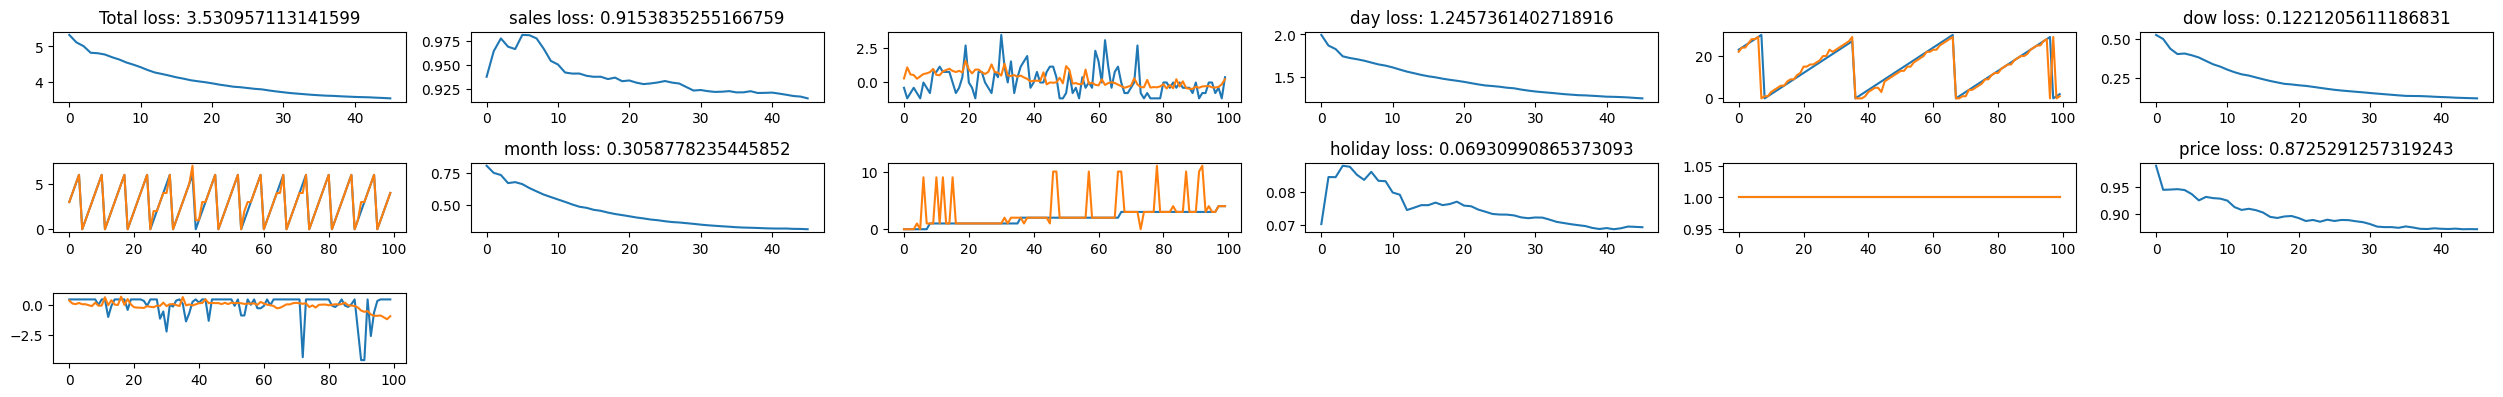

100%|██████████| 915/915 [04:19<00:00,  3.53it/s]


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, device, inverse_scale=False):
    loss_dict, pred_dict, y_dict = {}, {}, {}
    temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]

    for n, col in enumerate(temporal_cols):
        pred = temporal_output[col].squeeze()
        y = data[col].to(device).squeeze()
        
        if inverse_scale and col in data_info.processing_info["scaling_cols"]:
            pred = pred.detach().cpu()
            y = y.detach().cpu()

            new_pred, new_y = [], []
            scaler = data[f"{col}_scaler"]

            for i, s in enumerate(scaler):
                new_pred.append(torch.from_numpy(s.inverse_transform(pred[i].reshape(-1,1).numpy())))
                new_y.append(torch.from_numpy(s.inverse_transform(y[i].reshape(-1,1).numpy())))
            
            new_pred = torch.stack(new_pred, dim=0).squeeze().to(device)
            new_y = torch.stack(new_y, dim=0).squeeze().to(device)
            
            assert new_pred.shape == pred.shape and new_y.shape == y.shape

            pred, y = new_pred, new_y

        if col in data_info.processing_info["scaling_cols"]:
            loss = mse_loss(pred, y)
        elif col in data_info.processing_info["embedding_cols"]:
            pred_ = pred.reshape(-1, pred.shape[-1])
            y_ = y.reshape(-1).to(torch.long)
            loss = ce_loss(pred_, y_).reshape(y.shape)

        # Obtain mask
        padding_mask = padding_mask_dict["temporal_padding_mask"]
        masked_mask = idx_dict["temporal_masked_idx"].to(device)[:, :, 1:]
        masked_mask = (masked_mask==n).sum(dim=-1)

        total_mask = torch.where((padding_mask==1) & (masked_mask == 1), 1, 0)
        
        # Masked loss
        loss *= total_mask
        loss = loss.sum() / total_mask.sum()
        loss_dict[col] = loss
        pred_dict[col] = pred
        y_dict[col] = y
    
    return loss_dict, pred_dict, y_dict

def get_img_loss(img_output, data, idx_dict, device):
    loss_dict, pred_dict, y_dict = {}, {}, {}
    img_cols = data_info.modality_info["img"]
    
    for col in img_cols:
        pred = img_output[col].squeeze()[:, 1:, :]
        y = data[col].to(device).squeeze()
        y = patchify(y, patch_size=16)
        loss = mse_loss(pred, y)

        # Obtain mask
        masked_mask = idx_dict[f"{col}_masked_idx"]
        loss = torch.gather(loss, index=masked_mask.unsqueeze(-1).repeat(1, 1, loss.shape[-1]), dim=1)
        loss = loss.mean()
        
        loss_dict[col] = loss
        pred_dict[col] = pred
        y_dict[col] = y

    return loss_dict, pred_dict, y_dict

def get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, device):
    loss_dict, pred_dict, y_dict = {}, {}, {}
    nlp_cols = data_info.modality_info["nlp"]

    for col in nlp_cols:
        pred = nlp_output[col].squeeze()
        y = data[col].to(device).squeeze().to(torch.long)

        loss = ce_loss(pred.reshape(-1, pred.shape[-1]), y.reshape(-1))
        loss = loss.reshape(y.shape)
        
        # Obtain mask
        padding_mask = padding_mask_dict[f"{col}_revert_padding_mask"]
        masked_mask = idx_dict[f"{col}_masked_idx"]

        # Apply mask
        loss = torch.gather(loss, index=masked_mask, dim=-1)
        padding_mask = torch.gather(padding_mask, index=masked_mask, dim=-1)
        total_mask = torch.where((padding_mask==1) & (masked_mask==1), 1, 0)
        
        # Masked loss
        loss *= total_mask
        loss = loss.sum() / total_mask.sum()
        loss_dict[col] = loss
        pred_dict[col] = pred
        y_dict[col] = y
    
    return loss_dict, pred_dict, y_dict

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    eval_loss_li_dict, eval_mean_loss_li_dict = defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        # Train
        optimizer.zero_grad()
        model.train()
        temporal_output, img_output, nlp_output, self_attn_dict, cross_attn_dict, idx_dict, padding_mask_dict = model(data, remain_rto, device)

        temporal_loss_dict, temporal_pred_dict, temporal_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, device)
        img_loss_dict, img_pred_dict, img_y_dict = get_img_loss(img_output, data, idx_dict, device)
        # nlp_loss_dict, nlp_pred_dict, nlp_y_dict = get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, device)

        temporal_total_loss = torch.nansum(torch.stack(list(temporal_loss_dict.values())))
        # img_total_loss = torch.nansum(torch.stack(list(img_loss_dict.values())))
        # nlp_total_loss = torch.nansum(torch.stack(list(nlp_loss_dict.values())))

        temporal_loss_dict["total"] = temporal_total_loss
        img_loss_dict["total"] = img_total_loss
        # nlp_loss_dict["total"] = nlp_total_loss

        loss = temporal_total_loss + img_total_loss# + nlp_total_loss
        loss.backward()
        optimizer.step()

        if n % 20 == 0:
            idx = 0
            plt.figure(figsize=(25,13))
            clear_output(wait=True)
            nrows, ncols = 10, 6
            
            # Plot total loss
            plt.subplot(nrows, ncols, 1)
            total_loss = temporal_loss_dict["total"].item()
            loss_li_dict["total"].append(total_loss)
            mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())
            plt.plot(mean_loss_li_dict["total"])
            plt.title(f'Total loss: {mean_loss_li_dict["total"][-1]}')

            plot_idx = 2

            # Plot sample loss
            for n, (key, val) in enumerate(temporal_output.items()):
                # Plot loss
                plt.subplot(nrows, ncols, plot_idx)
                sample_loss = temporal_loss_dict[key].item()
                loss_li_dict[key].append(sample_loss)
                mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())
                plt.plot(mean_loss_li_dict[key])
                plt.title(f"{key} loss: {mean_loss_li_dict[key][-1]}")
                plot_idx += 1
                
                # Sample loss
                plt.subplot(nrows, ncols, plot_idx)
                sample_y = temporal_y_dict[key].detach().cpu()[idx]
                sample_pred = temporal_pred_dict[key].detach().cpu()[idx]
                if key in data_info.processing_info["embedding_cols"]:
                    sample_pred = torch.argmax(sample_pred, dim=-1)
                
                plt.plot(sample_y, label="y")
                plt.plot(sample_pred, label="pred")
                plot_idx += 1
            
            plt.tight_layout()
            plt.show()

epoch = 3
for e in range(epoch):
    train(e)
    scheduler.step()
    # raise